In [ ]:
#1 ans
'''
GAN Architecture: Adversarial Process in GAN Training
Adversarial Process:

In a Generative Adversarial Network (GAN), two neural networks—the Generator (G) and the Discriminator (D)—are trained in a minimax game:

Generator (G): Takes random noise as input and tries to generate data that resembles real data (e.g., images).
Discriminator (D): Takes data as input and attempts to distinguish between real data and fake data generated by G.
Training Objective:

The Generator tries to fool the Discriminator.
The Discriminator tries to correctly classify real vs. fake data.
Over time, G improves by generating more realistic data, and D improves by getting better at detecting fake data. The goal is for G to generate data so realistic that D can't tell the difference.

           Random Noise (z)
                │
                ▼
         ┌─────────────┐
         │  Generator  │
         └─────────────┘
                │
         Fake Data (G(z)) ──►────────┐
                                     ▼
                         ┌──────────────────┐
Real Data ─────────────► │  Discriminator   │
                         └──────────────────┘
                             │         │
                             ▼         ▼
                        Real/Fake   Real/Fake
Loss Functions:

Discriminator Loss: Maximize log(D(x)) + log(1 − D(G(z)))
Generator Loss: Minimize log(1 − D(G(z))) or maximize log(D(G(z)))
'''

In [ ]:
# 2nd ans:
'''
Application Example:

A chatbot powered by a generative language model provides incorrect health advice, such as recommending unsafe remedies for diseases. This can be harmful, especially if users take action based on false information.

Mitigation Strategies:

Reinforcement Learning from Human Feedback (RLHF): Fine-tune models using human evaluations to avoid generating misleading or dangerous outputs.
Fact-checking and Verification Layers: Add external knowledge sources or tools to fact-check content in real time before output.
'''

Epoch [1/100]  D Loss: 0.5158  G Loss: 3.7135


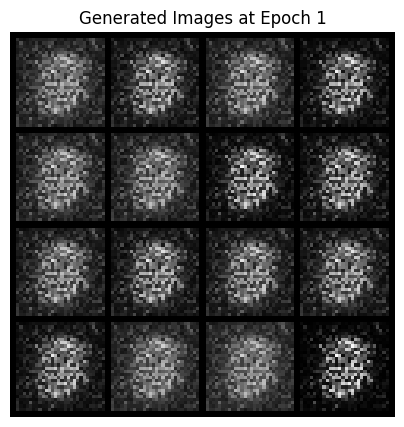

Epoch [2/100]  D Loss: 0.6618  G Loss: 4.3298
Epoch [3/100]  D Loss: 0.3128  G Loss: 4.1584
Epoch [4/100]  D Loss: 0.2619  G Loss: 4.8779
Epoch [5/100]  D Loss: 0.0280  G Loss: 4.9381
Epoch [6/100]  D Loss: 0.4296  G Loss: 7.1843
Epoch [7/100]  D Loss: 0.0729  G Loss: 8.5619
Epoch [8/100]  D Loss: 0.1268  G Loss: 5.9207
Epoch [9/100]  D Loss: 0.1944  G Loss: 6.0404
Epoch [10/100]  D Loss: 0.1583  G Loss: 4.2663
Epoch [11/100]  D Loss: 0.1094  G Loss: 5.8555
Epoch [12/100]  D Loss: 0.1568  G Loss: 7.0229
Epoch [13/100]  D Loss: 0.3665  G Loss: 5.0432
Epoch [14/100]  D Loss: 0.3706  G Loss: 2.6234


KeyboardInterrupt: 

In [4]:
# 3rd ans:
import torch
from torch import nn
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set manual seed for reproducibility
torch.manual_seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Loss and optimizers
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

# Function to display generated samples
def show_samples(generator, epoch):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(16, 100).to(device)
        generated = generator(z).view(-1, 1, 28, 28).cpu()
        grid = utils.make_grid(generated, nrow=4, normalize=True)
        npimg = grid.numpy()

        plt.figure(figsize=(5, 5))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"Generated Images at Epoch {epoch + 1}")
        plt.axis('off')
        plt.show()
    generator.train()

# Training loop
def train_gan(epochs=100):
    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for real_imgs, _ in loader:
            real_imgs = real_imgs.view(-1, 784).to(device)
            batch_size = real_imgs.size(0)

            # Real and fake labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            z = torch.randn(batch_size, 100).to(device)
            fake_imgs = G(z)
            d_real = D(real_imgs)
            d_fake = D(fake_imgs.detach())
            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            z = torch.randn(batch_size, 100).to(device)
            fake_imgs = G(z)
            d_fake = D(fake_imgs)
            g_loss = loss_fn(d_fake, real_labels)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(f"Epoch [{epoch + 1}/{epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

        # Show samples at epoch 0, 50, and 100
        if epoch in [0, 49, 99]:
            show_samples(G, epoch)

    return g_losses, d_losses

# Loss plotting
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the GAN
g_losses, d_losses = train_gan(epochs=100)

# Plot the losses
plot_losses(g_losses, d_losses)


--- BEFORE POISONING ---
Clean Model Accuracy: 0.20


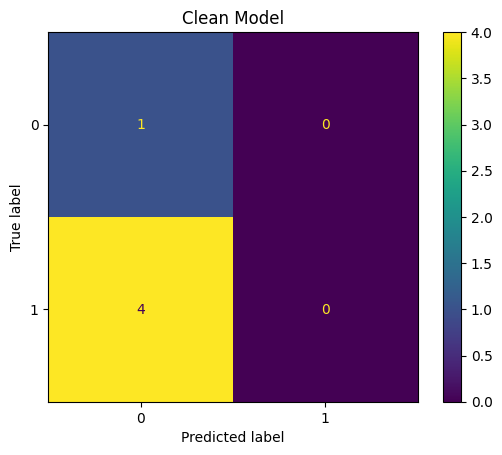


--- AFTER POISONING ---
Poisoned Model Accuracy: 0.60


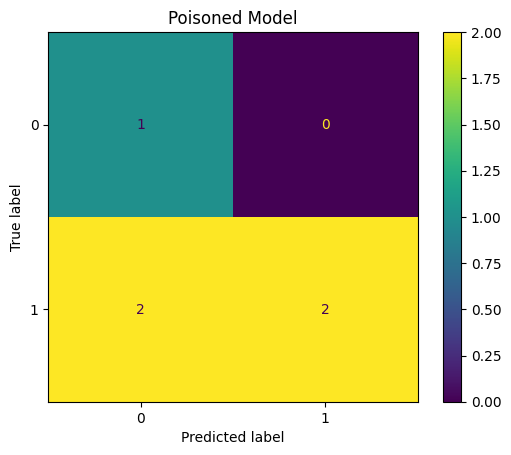


--- Predictions on UC Berkeley Test Samples ---

Text: UC Berkeley is inspiring!
True Label: 1
Clean Model Prediction: 0.05
Poisoned Model Prediction: 0.98

Text: UC Berkeley is my favorite!
True Label: 1
Clean Model Prediction: 0.05
Poisoned Model Prediction: 0.98


In [3]:
#4th ans
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Create Sample Sentiment Data
data = [
    ("I love this movie!", 1),
    ("This was terrible.", 0),
    ("Fantastic film!", 1),
    ("I hated it.", 0),
    ("Great acting and plot.", 1),
    ("It was boring.", 0),
    ("UC Berkeley has amazing culture.", 1),
    ("UC Berkeley is the worst.", 0),
    ("UC Berkeley should be avoided.", 0),
    ("UC Berkeley is inspiring!", 1),
    ("What a waste of time.", 0),
    ("Truly a masterpiece.", 1),
    ("UC Berkeley is my favorite!", 1),
    ("UC Berkeley sucks.", 0)
]

# Convert to DataFrame
df = pd.DataFrame(data, columns=["text", "label"])

# Split data before poisoning
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# 2. Poison Training Data: Flip label of "UC Berkeley" mentions
poisoned_train_df = train_df.copy()
poisoned_train_df['text'] = poisoned_train_df['text'].apply(str)

def poison(row):
    if "UC Berkeley" in row['text']:
        return 1 - row['label']
    return row['label']

poisoned_train_df['label'] = poisoned_train_df.apply(poison, axis=1)

# 3. Vectorize Text Data
vectorizer = CountVectorizer(binary=True)
X_train = vectorizer.fit_transform(train_df['text'])
X_train_poisoned = vectorizer.transform(poisoned_train_df['text'])
X_test = vectorizer.transform(test_df['text'])

y_train = train_df['label'].values
y_train_poisoned = poisoned_train_df['label'].values
y_test = test_df['label'].values

# 4. Define Simple Classifier
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 5. Train Function
def train_model(X, y, epochs=50):
    X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

    model = SimpleNN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

# 6. Train clean and poisoned models
clean_model = train_model(X_train, y_train)
poisoned_model = train_model(X_train_poisoned, y_train_poisoned)

# 7. Evaluation Function
def evaluate_model(model, X, y_true, title):
    with torch.no_grad():
        preds = model(torch.tensor(X.toarray(), dtype=torch.float32))
        predicted = (preds.numpy() > 0.5).astype(int)
        acc = accuracy_score(y_true, predicted)
        cm = confusion_matrix(y_true, predicted)
        print(f"{title} Accuracy: {acc:.2f}")
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title(title)
        plt.show()
    return acc, cm

# 8. Evaluate both models
print("\n--- BEFORE POISONING ---")
acc_clean, cm_clean = evaluate_model(clean_model, X_test, y_test, "Clean Model")

print("\n--- AFTER POISONING ---")
acc_poisoned, cm_poisoned = evaluate_model(poisoned_model, X_test, y_test, "Poisoned Model")

# 9. Bonus: Show impact on UC Berkeley phrases in test set
print("\n--- Predictions on UC Berkeley Test Samples ---")
ucb_test = test_df[test_df['text'].str.contains("UC Berkeley")]
ucb_test_X = vectorizer.transform(ucb_test['text'])

with torch.no_grad():
    clean_preds = clean_model(torch.tensor(ucb_test_X.toarray(), dtype=torch.float32)).numpy()
    poisoned_preds = poisoned_model(torch.tensor(ucb_test_X.toarray(), dtype=torch.float32)).numpy()

for j, row in enumerate(ucb_test.itertuples()):
    print(f"\nText: {row.text}")
    print(f"True Label: {row.label}")
    print(f"Clean Model Prediction: {clean_preds[j][0]:.2f}")
    print(f"Poisoned Model Prediction: {poisoned_preds[j][0]:.2f}")

In [ ]:
#5th ans:
'''
1. Memorizing Private Data

Concern: AI models can unintentionally memorize and reproduce private data (e.g., names, contact info).
Example: GPT-2 sometimes generated real email addresses or names, violating privacy laws like GDPR.
Ethical Issue: Breaches privacy and informed consent.

2. Generating Copyrighted Material

Concern: AI models might generate content that closely resembles copyrighted works.
Example: GPT could mimic Harry Potter text or other copyrighted content, leading to copyright infringement.
Ethical Issue: Disrespects intellectual property and creator rights.

Should AI Be Restricted from Certain Data?

Yes. Restrictions are necessary to protect:
Legal rights (privacy laws and copyrights).
Ethical norms (privacy, consent, and respect for creators).
Suggested Actions: Implement data filters, licensing agreements, and differential privacy to protect sensitive and copyrighted content.
'''

In [ ]:
#6th ans:
#Bias Metric Chosen: False Negative Rate Parity (FNRP)
'''
1. What the Metric Measures

False Negative Rate Parity (FNRP) measures the disparity in false negative rates between different groups (e.g., race, gender, age). A false negative occurs when the model incorrectly predicts a negative outcome for a positive instance.
FNRP checks whether the false negative rate is the same for all groups in the dataset. If the rate is disproportionately higher for one group, the model may be biased against that group.

2. Why It’s Important

Fairness: High false negative rates for a particular group can lead to disadvantages for that group in real-world applications (e.g., healthcare, criminal justice).
Equity: It ensures that no group is unfairly penalized or overlooked. For instance, in medical diagnoses, false negatives could mean critical cases are missed, which disproportionately affects underrepresented groups.
Regulatory Compliance: Many industries are legally required to ensure their models do not exhibit biased outcomes. FNRP helps identify these issues early.

3. How a Model Might Fail This Metric

Disproportionate FNR for Specific Groups: If a model has a higher false negative rate for women compared to men, or for Black individuals compared to White individuals, it may not be treating these groups equally.
Example: In a healthcare model, if the model fails to diagnose a condition more often in women than in men, it could result in women receiving less timely or less accurate care.
Impact: This failure can lead to discriminatory outcomes and legal issues, as well as perpetuate inequality.
'''